# Example 4 - Localized Vortices

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from subprocess import Popen, PIPE

# Path to the PULSE executable
PULSE_PATH = "../../pulse.exe"

# Pulse loads local resources, so we need to set the working directory to the location of the executable
PULSE_CWD = os.path.dirname( os.path.realpath(PULSE_PATH) )

# Path to the data folder relative to PULSE_CWD
DATA_PATH = "examples/example_4/data3/"

# Create results and load folders
result_path = os.path.join(PULSE_CWD, DATA_PATH, "results")

# Create Target Directories
os.makedirs(result_path, exist_ok=True)

# System Parameters
grid_size = 500                  # Grid Size, int this case 200x200
x_max = 200                      # mum; Maximum Distance in one direction, meaning the grid will be from -100mum to 100mum
effective_mass = 5.6856E-4       # kg; Effective Mass of the electron, scaled
gamma_c = 0.15                   # Polariton Loss Rate
gamma_r = 1.5 * gamma_c          # Reservoir Loss Rate
R = 0.01                         # Condensation Rate
g_c = 3E-6                       # Polariton-Polariton Coupling
g_r = 2*g_c                      # Polariton-Reservoir Coupling
deltaLT = 0.000025               # TE/TM interaction
g_pm = 0.2*g_c                   # TE/TM Whatever

# Special Parameters for this example
pump_amp = 100                  # Pulse Amplitude

# Additional Parameters not required by PULSE:
hbar = 6.582119569E-4
dx = x_max/grid_size

# Matrix Generation

In this example, we are fine with using PULSE's ability to generate spacial shapes via its envelope syntax.


# Execute Pulse

We create a function to generate the PULSE compatible commandline runstring and execute a test calculation.

We also plot the test calculation. The resulting density should resemble a hexagon.

In [9]:
# Runstring generator
def generate_runstring( *, t_max: float, m_plus: int = 0, m_minus: int = 0, pump_sigma: float = 4.5, output_suffix: str = "", simple_output: bool = True ):
    # Generate Load Path relative to PULSE_CWD
    relative_result_path = os.path.relpath(result_path, PULSE_CWD).replace("\\", "/")
    # Append output suffix
    relative_result_path = os.path.join(relative_result_path, output_suffix)
    # Build runstring
    runstring = f"{PULSE_PATH} "
    runstring += f"--path {relative_result_path} "      # Set the output path
    runstring += f"--N {grid_size} {grid_size} "        # Set the grid size in points
    runstring += f"--L {x_max} {x_max} "                # Set the grid size in mum
    runstring += f"--meff {effective_mass} "            # Set the effective mass
    runstring += f"--tmax {t_max} "                     # Set the end time
    runstring += "--outEvery 50 "                       # Set sample rate to 50ps. We dont need intermediate results, so setting this high will increase the simulation speed
    runstring += f"--gc {g_c} "                         # Set the coupling constants
    runstring += f"--gr {g_r} "                         # Set the coupling constants
    runstring += f"--R {R} "                            # Set the condensation rate
    runstring += f"--gammaR {gamma_r} "                 # Set the reservoir loss rate
    runstring += f"--gammaC {gamma_c} "                 # Set the polariton loss rate
    runstring += f"--deltaLT {deltaLT} "                # Set the TE/TM interaction
    runstring += f"--g_pm {g_pm} "                      # Set the TE/TM Whatever
    #runstring += "-nosfml "                             # Disable SFML output
    runstring += "--fftEvery 5 "                        # Set the FFT sample rate. Even though we dont need the FFT, setting this high will increase the simulation speed as the FFT is still calculated.
    runstring += "--initRandom 1E-7 random "            # Randomly initialize the wavefunction since we dont load an initial wavefunction
    runstring += "--boundary zero zero "                # Set the boundary conditions
    runstring += f"--output { 'wavefunction' if simple_output else 'all'} "                        # Output only the wavefunction
    runstring += "-tetm "                               # Enable TE/TM interaction
    runstring += "--threads 2 "                         # Use 2 CPU Threads
    # Add a pump to both states as well as the initial states
    runstring += f"--pump {pump_amp} add {pump_sigma} {pump_sigma} 0 0 both 1 none gauss+noDivide+ring " 
    runstring += f"--initialState 1 add {pump_sigma} {pump_sigma} 0 0 plus 1 {m_plus} gauss+noDivide+ring " 
    runstring += f"--initialState 1 add {pump_sigma} {pump_sigma} 0 0 minus 1 {m_minus} gauss+noDivide+ring " 
    return runstring

In [14]:
# Test Calculation, Execute PULSE
runstring = generate_runstring( t_max = 500, m_plus = 0, m_minus = -4, pump_sigma = 12/np.sqrt(2), simple_output=False)
# Call the runstring and wait for the subprocess to finish
process = Popen( runstring.split(), stdout=PIPE, stderr=PIPE, cwd = PULSE_CWD )
stdout, stderr = process.communicate()
# Print the output
print(stdout.decode("utf-8"))

---------------------------- Inputting System Parameters --------------------------
[ i ] Subgrid Configuration: 1x1
[ i ] Subgrid Size: 500x500
[ i ] Halo Size for iterator 'rk4' = 4
[ i ] Parsing envelope 'pump'
[ v ] Added Spacial Component to Envelope 'pump'
[ i ] Parsing envelope 'initialState'
[ v ] Added Spacial Component to Envelope 'initialState'
[ i ] Parsing envelope 'initialState'
[ v ] Added Spacial Component to Envelope 'initialState'
[ i ] Successfully created directory 'examples/example_4/data3/results\/'
[ i ] Creating Solver...
-------------------- Initializing Host and Device Matrices ------------------------
[ i ] Allocating 1.968872 MB for 1x500x500 device matrix 'wavefunction_plus' with halo 4 and 1 total subgrids, total allocated device space: 1.968872 MB.
[ i ] Full grid buffer for size 250000 not found, creating new buffer.
[ i ] Allocating 1.968872 MB for 1x500x500 device matrix 'reservoir_plus' with halo 4 and 1 total subgrids, total allocated device space: 3

### Plotting
PULSE saves outputs using one row per line, saving real parts first. This means, for our NxN complex matrices, PULSE will output a textfile containing a 2NxN (rows,cols) matrix. When loading the real and imaginary parts of the result, we can also calculate the phase using `np.angle`. Since we did not precalculate any of the matrices, we also do not have and X,Y matrix at this point in time. We could generate an X,Y meshgrid here, but we can also simply plot the matrix without any bounds.

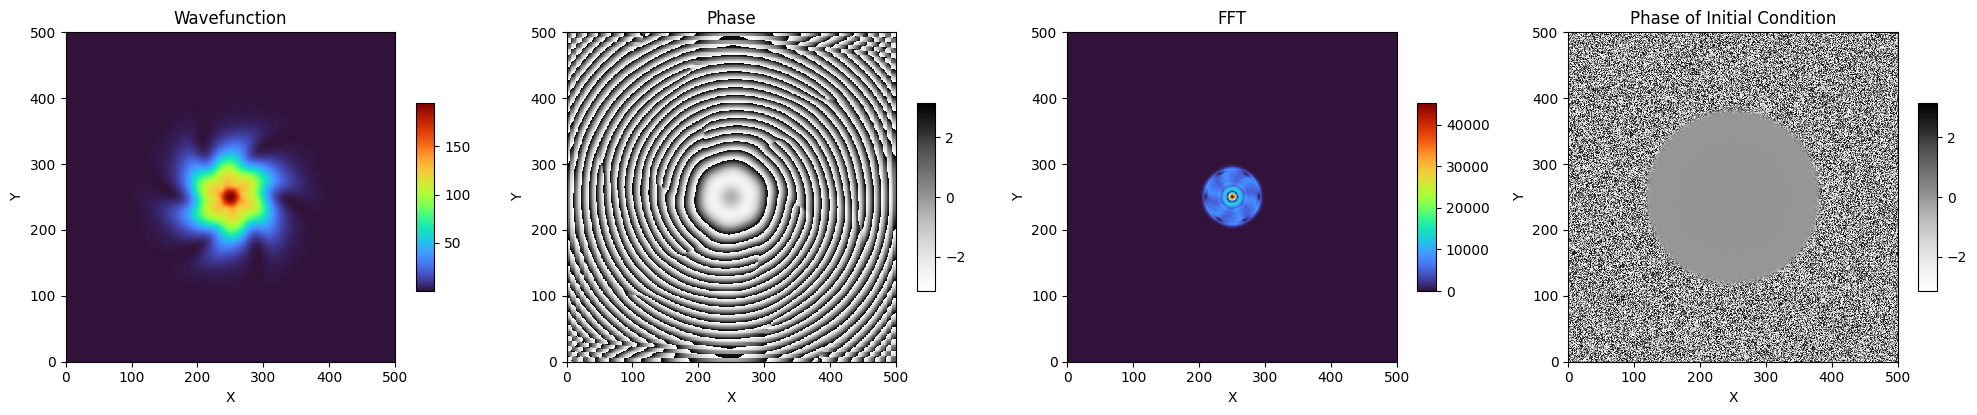

In [15]:
# Plot Results
data = np.loadtxt( os.path.join(result_path, "wavefunction_plus.txt") )
re,im = data[:grid_size,:], data[grid_size:,:]
psi = (re + 1j*im).reshape(grid_size,grid_size)
data = np.loadtxt( os.path.join(result_path, "initial_wavefunction_plus.txt") )
re,im = data[:grid_size,:], data[grid_size:,:]
initial_psi = (re + 1j*im).reshape(grid_size,grid_size)
fft = np.fft.fftshift( np.fft.fft2(psi) )

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,5))
ax1.set_title("Wavefunction")
plt_psi = ax1.pcolormesh(np.abs(psi)**2, cmap="turbo")
ax2.set_title("Phase")
plt_phase = ax2.pcolormesh(np.angle(psi), cmap="Grays")
ax3.set_title("FFT")
plt_fft = ax3.pcolormesh(np.abs(fft), cmap="turbo")
ax4.set_title("Phase of Initial Condition")
plt_phase = ax4.pcolormesh(np.angle(initial_psi), cmap="Grays")

for ax,plot in zip((ax1,ax2,ax3,ax4),(plt_psi,plt_phase,plt_fft,plt_phase)):
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect("equal")
    fig.colorbar(plot, ax=ax, shrink=0.4, aspect=10)

plt.tight_layout()

## Define Charges
We define the charges using m_+ + m_-  and m_+ - m_-.

In [16]:
settings = [
    (-4, 0, 12),
    (-3,1, 10),
    (-2,2, 8),
    (-1,3, 10),
    (0,4, 12),

    (-3,0, 10),
    (-2,1, 8),
    (-1,2, 8),
    (0,3, 10),

    (-3,-1, 10),
    (-2,0, 8),
    (-1,1,4.5),
    (0,2,8),
    (1,3,10),

    (-2,-1,8),
    (-1,0,4.5),
    (0,1,4.5),
    (1,2,8),

    (-2,-2,8),
    (-1,-1,4.5),
    (0,0,4.5),
    (1,1,4.5),
    (2,2,8),

    (-1,-2,8),
    (0,-1,4.5),
    (1,0,4.5),
    (2,1,8),

    (-1,-3,10),
    (0,-2,8),
    (1,-1,4.5),
    (2,0,8),
    (3,1,10),

    (0,-3,10),
    (1,-2,8),
    (2,-1,8),
    (3,0,10),

    (0,-4,12),
    (1,-3,10),
    (2,-2,8),
    (3,-1,10),
    (4,0,12),
]

t_max = 500

for m_plus, m_minus, pump_sigma  in settings:
    runstring = generate_runstring( t_max = t_max, m_plus = m_plus, m_minus = m_minus, pump_sigma = pump_sigma/np.sqrt(2), output_suffix = f"m_plus_{m_plus}_m_minus_{m_minus}_sigma_{pump_sigma}", simple_output=False )
    process = Popen( runstring.split(), stdout=PIPE, stderr=PIPE, cwd = PULSE_CWD )
    stdout, stderr = process.communicate()
    

In [17]:
wavefunctions_plus, wavefunctions_minus = [], []
ffts_plus, ffts_minus = [], []

for m_plus, m_minus, pump_sigma  in settings:
    for prefix,(target_plus,target_minus) in zip( ["fft","wavefunction"],[(ffts_plus,ffts_minus),(wavefunctions_plus,wavefunctions_minus)] ):
        data_plus = np.loadtxt( os.path.join(result_path, f"m_plus_{m_plus}_m_minus_{m_minus}_sigma_{pump_sigma}", f"{prefix}_plus.txt") )
        data_minus = np.loadtxt( os.path.join(result_path, f"m_plus_{m_plus}_m_minus_{m_minus}_sigma_{pump_sigma}", f"{prefix}_minus.txt") )
        re_plus,im_plus = data_plus[:grid_size,:], data_plus[grid_size:,:]
        re_minus,im_minus = data_minus[:grid_size,:], data_minus[grid_size:,:]
        plus = (re_plus + 1j*im_plus).reshape(grid_size,grid_size)
        minus = (re_minus + 1j*im_minus).reshape(grid_size,grid_size)
        target_plus.append(plus)
        target_minus.append(minus)

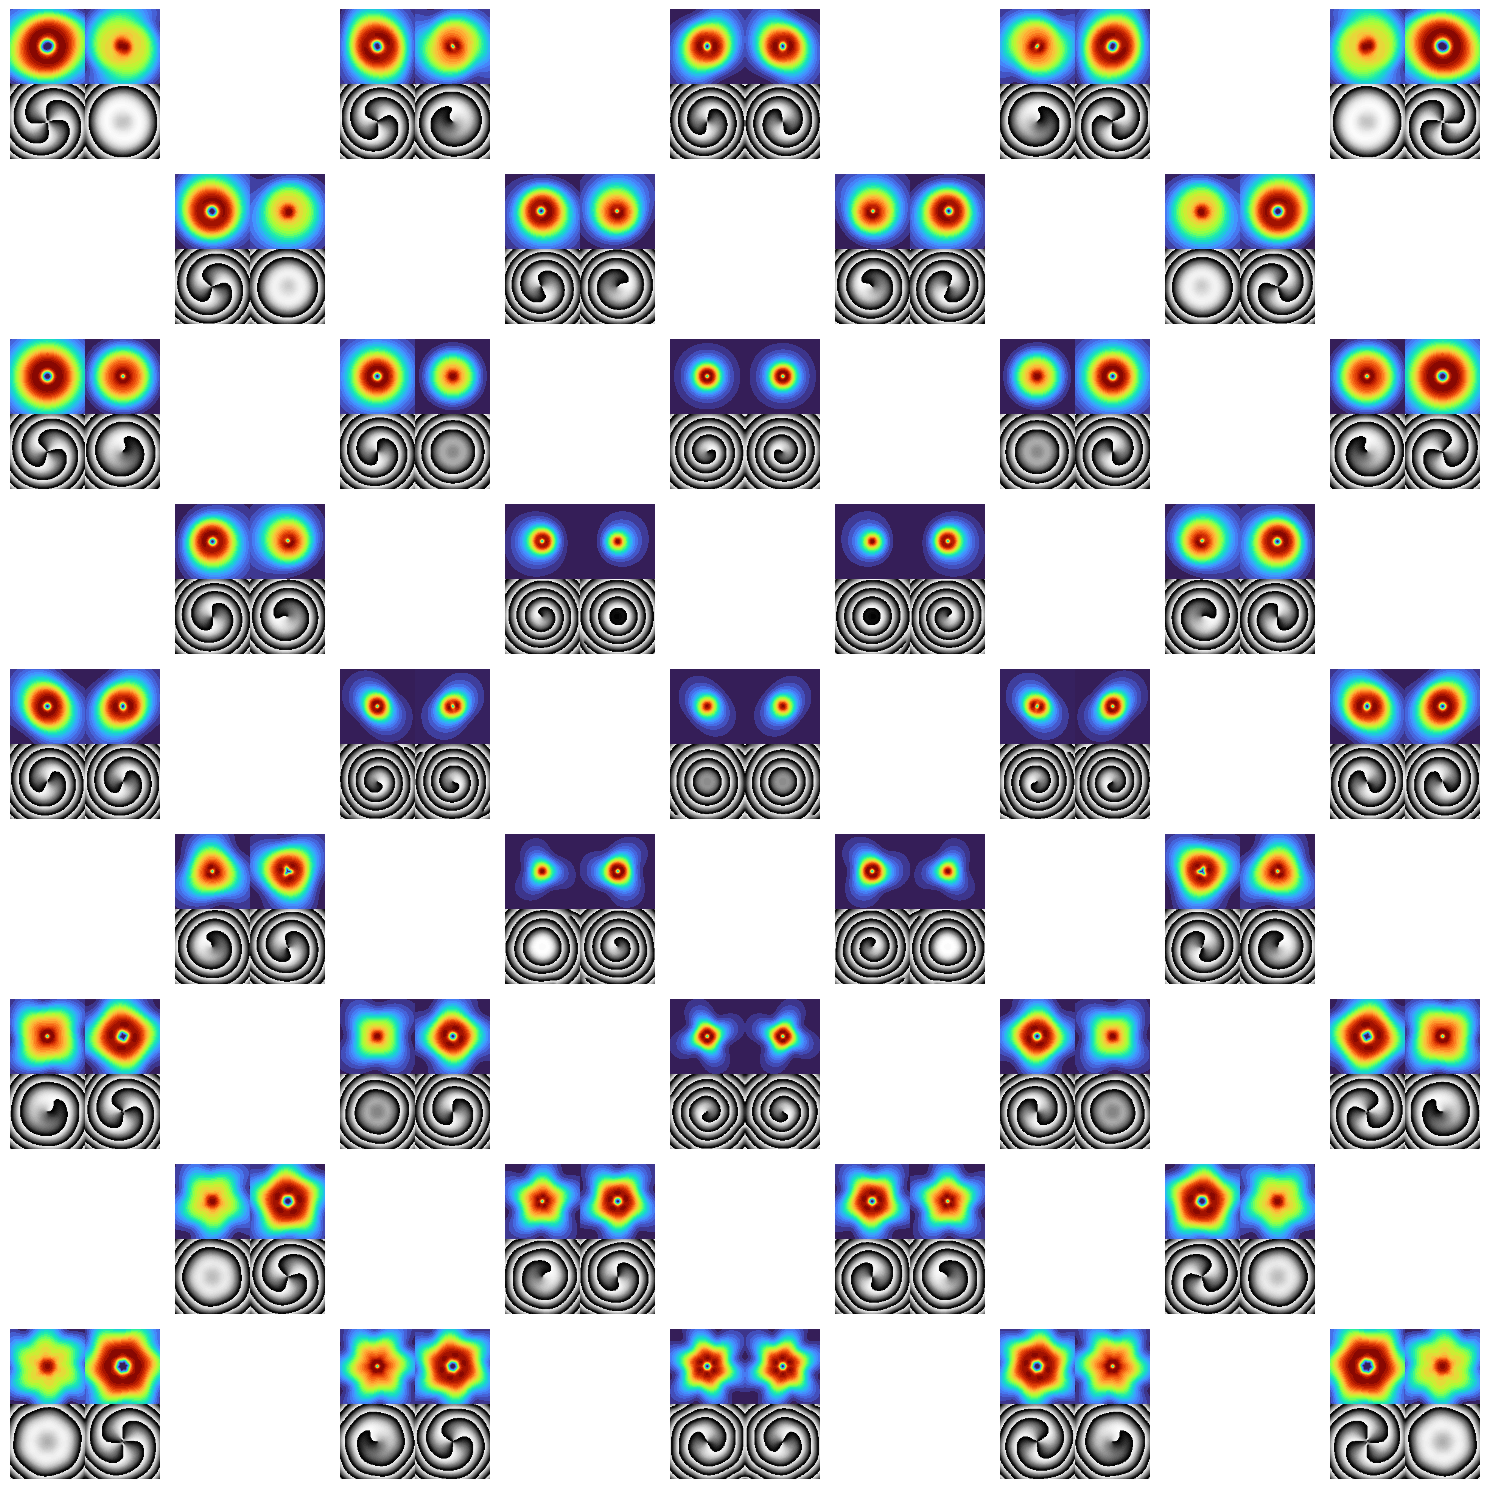

In [18]:
num_plots = len(settings)

fig,axes = plt.subplots(9,9,figsize=(15,15))

[ax.axis("off") for ax in axes.flat]

x = np.linspace(-x_max, x_max, grid_size)
y = np.linspace(-x_max, x_max, grid_size)
X,Y = np.meshgrid(x,y)

plotwindow_map = {
    4.5 : 30,
    8 : 50,
    10 : 60,
    12 : 70,
    -4.5 : 50,
    -8 : 50,
    -10 : 50,
    -12 : 50,
}

for i,(ax,plus,minus) in enumerate(zip(axes.flat[::2], wavefunctions_plus, wavefunctions_minus)):
    plot_window = plotwindow_map[-settings[i][2]]
    plot_plus = plus[np.logical_and(np.abs(X) < plot_window, np.abs(Y) < plot_window)]
    plot_minus = minus[np.logical_and(np.abs(X) < plot_window, np.abs(Y) < plot_window)]
    plot_X = X[np.logical_and(np.abs(X) < plot_window, np.abs(Y) < plot_window)]
    plot_Y = Y[np.logical_and(np.abs(X) < plot_window, np.abs(Y) < plot_window)]
    ax.tricontourf(plot_X,plot_Y,np.abs(plot_plus)**2, levels = 30, cmap = "turbo")#, vmin=0, vmax=160)
    ax.tricontourf(plot_X+2*plot_window,plot_Y,np.abs(plot_minus)**2, levels = 30, cmap = "turbo")#, vmin=0, vmax=160)
    ax.tricontourf(plot_X,plot_Y-2*plot_window,np.angle(plot_plus), levels = 50, cmap = "Grays")
    ax.tricontourf(plot_X+2*plot_window,plot_Y-2*plot_window,np.angle(plot_minus), levels = 50, cmap = "Grays")

    ax.set_aspect("equal")
    ax.axis("off")
plt.tight_layout()